# matplotlib.financeでローソク足

## データの作成
ランダムウォークで架空の為替チャートを作成します。

ランダム生成です。

私の今年のドル円相場の予想ではありませんので、このチャートに乗っ取った投資判断は自己責任でお願いします。

In [1]:
import numpy as np
import pandas as pd

def randomwalk(periods, start=pd.datetime.today().date(), index=None, name=None, tick=1, freq='B'):
    """periods日分だけランダムウォークを返す"""
    if not index:
        index = pd.date_range(start=start, periods=periods, freq=freq)  # 今日の日付からperiod日分の平日
    bullbear = pd.Series(tick * np.random.randint(-1, 2, periods),
                         index=index, name=name)  # unit * (-1,0,1のどれか)を吐き出すSeries
    price = bullbear.cumsum()  # 累積和
    return price

In [2]:
np.random.seed(1)  # ランダムステートのリセット。常に同じランダムウォークが出来上がる
rw = randomwalk(60*24*90, freq='T', tick=0.01)
rw.head(5)

2017-03-18 00:00:00    0.00
2017-03-18 00:01:00   -0.01
2017-03-18 00:02:00   -0.02
2017-03-18 00:03:00   -0.02
2017-03-18 00:04:00   -0.02
Freq: T, dtype: float64

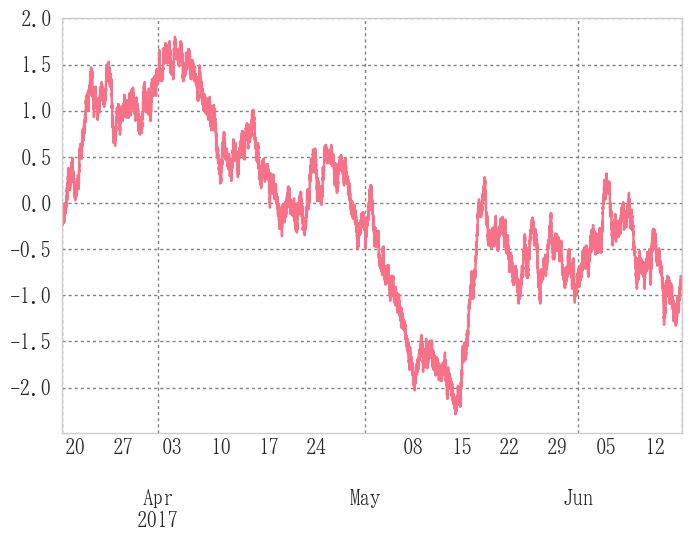

In [3]:
rw.plot()

最小tick0.01円の1分足を30日分生成

In [4]:
df = rw.resample('B').ohlc() + 115  # 初期値は115円
df.head()

,open,high,low,close
2017-03-17,115.00,115.49,114.76,115.15
2017-03-20,115.14,115.69,115.07,115.65
2017-03-21,115.66,116.22,115.64,116.21
2017-03-22,116.20,116.47,115.93,116.11
2017-03-23,116.10,116.31,115.90,116.14


resampleメソッド使って平日のみの日足(オプション how='B')に直し、open, high, low, closeの4本値(ohcl)にまとめました。

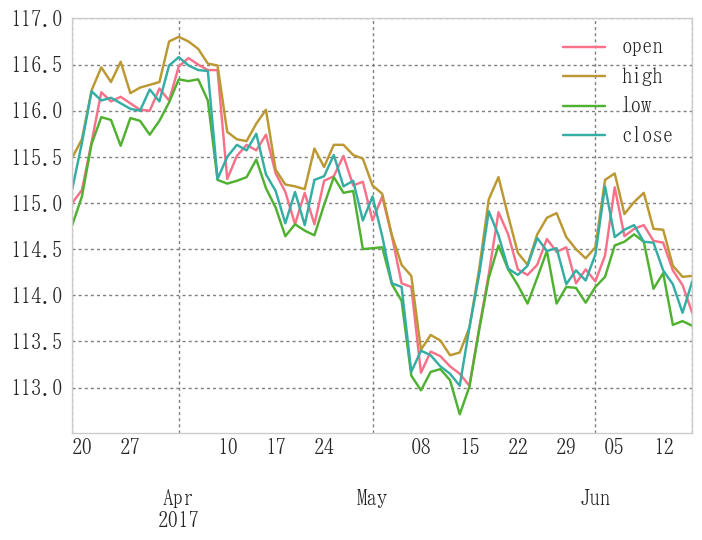

In [5]:
df.plot()

4本値グラフは上のように見づらいので、ローソク足に直します。

## 参考1
参考: [stack over flow - how to plot ohlc candlestick with datetime in matplotlib?](http://stackoverflow.com/questions/36334665/how-to-plot-ohlc-candlestick-with-datetime-in-matplotlib)

(<matplotlib.figure.Figure at 0x1f9a7534d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f9a7548278>)

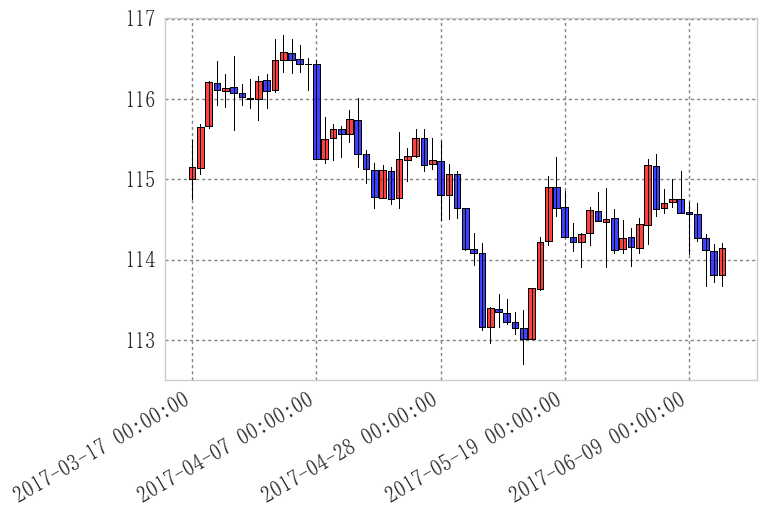

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib import ticker
import matplotlib.dates as mdates
import pandas as pd

def candlechart(ohlc, width=0.8):
    """入力されたデータフレームに対してローソク足チャートを返す
        引数:
            * ohlc:
                *データフレーム
                * 列名に'open'", 'close', 'low', 'high'を入れること
                * 順不同"
            * widrh: ローソクの線幅
        戻り値: ax: subplot"""
    fig, ax = plt.subplots()
    # ローソク足
    mpf.candlestick2_ohlc(ax, opens=ohlc.open.values, closes=ohlc.close.values,
                          lows=ohlc.low.values, highs=ohlc.high.values,
                          width=width, colorup='r', colordown='b')

    # x軸を時間にする
    xdate = ohlc.index
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

    def mydate(x, pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

    fig.autofmt_xdate()
    fig.tight_layout()

    return fig, ax

candlechart(df)

## 参考2
参考: [Qiita - Pythonでローソク足チャートの表示（matplotlib編）
](http://qiita.com/toyolab/items/1b5d11b5d376bd542022)

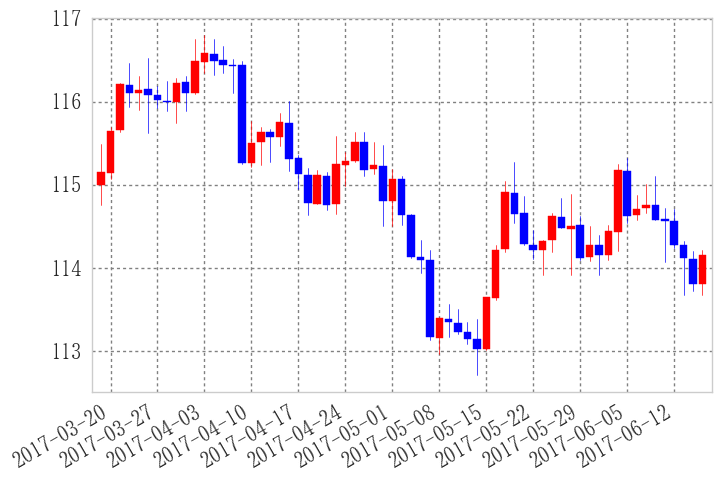

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib import ticker
import matplotlib.dates as mdates
import pandas as pd

fig = plt.figure()
ax = plt.subplot()

ohlc = np.vstack((range(len(df)), df.values.T)).T #x軸データを整数に
mpf.candlestick_ohlc(ax, ohlc, width=0.8, colorup='r', colordown='b')

xtick0 = (5-df.index[0].weekday())%5 #最初の月曜日のインデックス

plt.xticks(range(xtick0,len(df),5), [x.strftime('%Y-%m-%d') for x in df.index][xtick0::5])
ax.grid(True) #グリッド表示
ax.set_xlim(-1, len(df)) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット

## SMA(Simple Moving Average)の追加

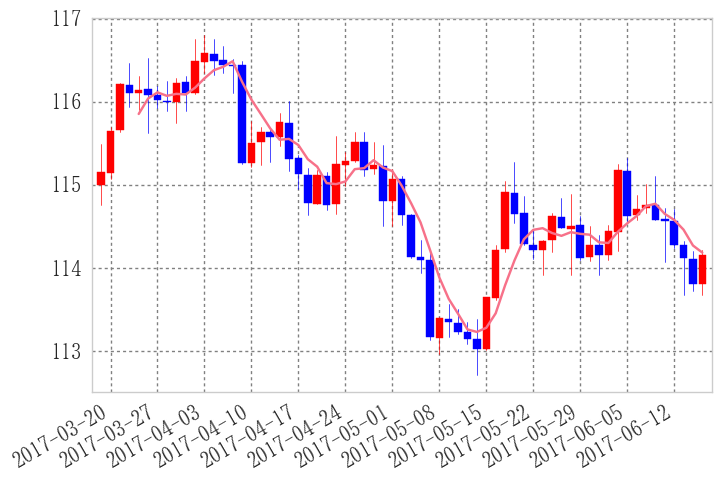

In [8]:
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from randomwalk import *

fig = plt.figure()
ax = plt.subplot()

# candle
ohlc = np.vstack((range(len(df)), df.values.T)).T  # x軸データを整数に
mpf.candlestick_ohlc(ax, ohlc, width=0.8, colorup='r', colordown='b')

# sma
sma = df.close.rolling(5).mean()
vstack = np.vstack((range(len(sma)), sma.values.T)).T  # x軸データを整数に
ax.plot(vstack[:, 0], vstack[:, 1])

# xticks
xtick0 = (5 - df.index[0].weekday()) % 5  # 最初の月曜日のインデックス
plt.xticks(range(xtick0, len(df), 5), [x.strftime('%Y-%m-%d') for x in df.index][xtick0::5])
ax.grid(True)  # グリッド表示
ax.set_xlim(-1, len(df))  # x軸の範囲
fig.autofmt_xdate()  # x軸のオートフォーマット
plt.show()


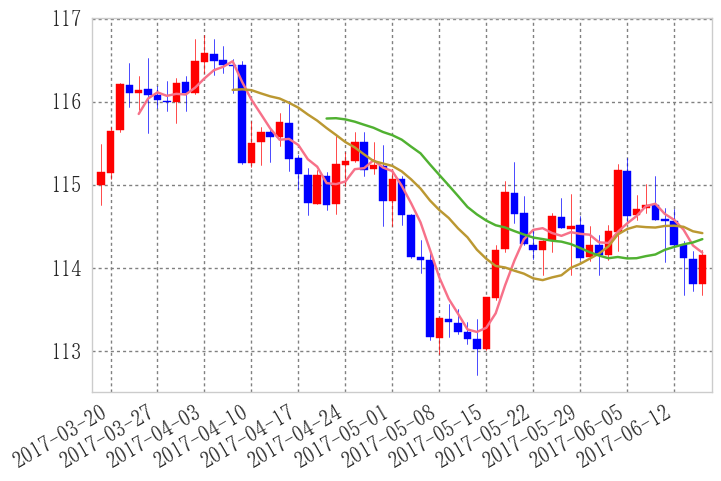

In [9]:
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def sma(ohlc, period):
    sma = ohlc.close.rolling(period).mean()
    vstack = np.vstack((range(len(sma)), sma.values.T)).T  # x軸データを整数に
    return ax.plot(vstack[:, 0], vstack[:, 1])

fig = plt.figure()
ax = plt.subplot()

# candle
ohlc = np.vstack((range(len(df)), df.values.T)).T  # x軸データを整数に
mpf.candlestick_ohlc(ax, ohlc, width=0.8, colorup='r', colordown='b')

# sma
sma(df, 5)
sma(df, 15)
sma(df, 25)


# xticks
xtick0 = (5 - df.index[0].weekday()) % 5  # 最初の月曜日のインデックス
plt.xticks(range(xtick0, len(df), 5), [x.strftime('%Y-%m-%d') for x in df.index][xtick0::5])
ax.grid(True)  # グリッド表示
ax.set_xlim(-1, len(df))  # x軸の範囲
fig.autofmt_xdate()  # x軸のオートフォーマット
plt.show()


# plotlyでローソク足

## plotlyの練習
参考: [Qiita - [Python] Plotlyでぐりぐり動かせるグラフを作る
](http://qiita.com/inoory/items/12028af62018bf367722)

初めてplotlyを使うので、やりかた

`conda install plotly`

でインストールして以下のようにインポート。

アカウントを作る必要あるやらないやら情報がいろいろありますが、規制緩和されて、今では無料で結構やりたい放題みたいです。

In [10]:
import plotly as py
py.offline.init_notebook_mode(connected=False) 

適当なサンプルデータを作ります。

In [11]:
fo = [[2000,1190547,1.36],
    [2001,1170662,1.33],
    [2002,1153855,1.32],
    [2003,1123610,1.29],
    [2004,1110721,1.29],
    [2005,1062530,1.26],
    [2006,1092674,1.32],
    [2007,1089818,1.34],
    [2008,1091156,1.37],
    [2009,1070035,1.37],
    [2010,1071304,1.39],
    [2011,1050806,1.39],
    [2012,1037101,1.41],
    [2013,1029816,1.43],
    [2014,1003532,1.42],
    [2015,1005656,1.46]]
raw = pd.DataFrame(fo, columns=['year', 'births', 'birth rate'])
raw

,year,births,birth rate
0,2000,1190547,1.36
1,2001,1170662,1.33
2,2002,1153855,1.32
3,2003,1123610,1.29
4,2004,1110721,1.29
5,2005,1062530,1.26
6,2006,1092674,1.32
7,2007,1089818,1.34
8,2008,1091156,1.37
9,2009,1070035,1.37


In [12]:
data = [
    py.graph_objs.Scatter(y=raw["births"], name="births"),
]
layout = py.graph_objs.Layout(
    title="title",
    legend={"x":0.8, "y":0.1},
    xaxis={"title":""},
    yaxis={"title":""},
)
fig = py.graph_objs.Figure(data=data, layout=layout)
py.offline.iplot(fig, show_link=False)

In [13]:
data = [
    py.graph_objs.Bar(x=raw["year"], y=raw["births"], name="Births"),
    py.graph_objs.Scatter(x=raw["year"], y=raw["birth rate"], name="Birth Rate", yaxis="y2")
]
layout = py.graph_objs.Layout(
    title="Births and Birth Rate in Japan",
    legend={"x":0.8, "y":0.1},
    xaxis={"title":"Year"},
    yaxis={"title":"Births"},
    yaxis2={"title":"Birth Rate", "overlaying":"y", "side":"right"},
)
fig = py.graph_objs.Figure(data=data, layout=layout)
py.offline.iplot(fig)
#py.offline.plot(fig)

操作方法

* マウスオーバーとかで数値の表示
* ドラッグで拡大
* ダブルクリックで元のビューに戻る

## 為替チャート
参考: [Qiita - Pythonでローソク足チャートの表示（Plotly編）](http://qiita.com/toyolab/items/db8a1e539d4f995079d5)

In [14]:
from plotly.offline import init_notebook_mode, iplot
from plotly.tools import FigureFactory as FF
init_notebook_mode(connected=True) # Jupyter notebook用設定

### 通常のプロット
candleチャートのAPIは用意されているので、open, high, low, closeのデータが用意されていれば簡単に作成できる。

ただし、平日のみの表示ができない。

In [15]:
fig = FF.create_candlestick(df.open, df.high, df.low, df.close, dates=df.index)
py.offline.iplot(fig)

### 平日のみのプロット
参考先の方が平日のみのindexに直していた。

拡大縮小自由自在なplotlyを使わない手はないですね、っていうのがまとめです。

In [16]:
fig = FF.create_candlestick(df.open, df.high, df.low, df.close)

xtick0 = (5-df.index[0].weekday())%5 #最初の月曜日のインデックス
fig['layout'].update({
    'xaxis':{
        'showgrid': True,
        'ticktext': [x.strftime('%Y-%m-%d') for x in df.index][xtick0::5],
        'tickvals': np.arange(xtick0,len(df),5)
    }
})

py.offline.iplot(fig)

## 指標の追加

In [17]:
def sma(data, window, columns='close'):
    return data[columns].rolling(window).mean()

sma5 = sma(df, 5)

In [18]:
from plotly.graph_objs import *
fig = FF.create_candlestick(df.open, df.high, df.low, df.close, dates=df.index)

add_line = Scatter( x=df.index,  y=df.close,  name= 'close values',
                   line=Line(color='black'))
fig['data'].extend([add_line])

py.offline.iplot(fig, filename='candlestick_and_trace', validate=False)

In [19]:
from plotly.graph_objs import *
fig = FF.create_candlestick(df.open, df.high, df.low, df.close, dates=df.index)
add_line = [Scatter(x=df.index, y=df.close.rolling(5).mean(), name='SMA5', line=Line(color='r')),
            Scatter(x=df.index, y=df.close.rolling(15).mean(), name='SMA15', line=Line(color='b')),
            Scatter(x=df.index, y=df.close.rolling(25).mean(), name='SMA25', line=Line(color='g'))]

fig['data'].extend(add_line)
fig['layout'].update({'xaxis':{'showgrid': True}})

py.offline.iplot(fig, filename='candlestick_and_trace', validate=False)

## SMA, EMA比較
新たなチャートの作成

In [20]:
np.random.seed(10)
ra = randomwalk(60*24*360, freq='T', tick=0.01) + 115
df1 = ra.resample('B').ohlc()

In [29]:
import plotly.graph_objs as go
fig = FF.create_candlestick(df1.open, df1.high, df1.low, df1.close, dates=df1.index)
add_line = [go.Scatter(x=df1.index, y=df1.close.rolling(75).mean(), name='SMA75', line=Line(color='r')),
            go.Scatter(x=df1.index, y=df1.close.ewm(75).mean(), name='EMA75', line=Line(color='b'))]

fig['data'].extend(add_line)
fig['layout'].update({'xaxis':{'showgrid': True}})
    
py.offline.iplot(fig, filename='candlestick_and_trace', validate=False)

In [71]:
import plotly.graph_objs as pyg
from datetime import datetime

def to_unix_time(*dt):
    """datetimeをunix秒に変換
    引数: datetimeの入ったリスト
    戻り値: unix秒に直されたリスト"""
    epoch =  datetime.utcfromtimestamp(0)
    ep = [(i - epoch).total_seconds() * 1000 for i in list(*dt)]
    return ep

fig = FF.create_candlestick(df1.open, df1.high, df1.low, df1.close, dates=df1.index)
add_line = [pyg.Scatter(x=df1.index, y=df1.close.rolling(75).mean(), name='SMA75', line=Line(color='r')),
            pyg.Scatter(x=df1.index, y=df1.close.ewm(75).mean(), name='EMA75', line=Line(color='b')),
            pyg.Scatter(x=df1.index, y=df1.close.rolling(75).mean(), name='SMA75', mode='markers'),
            pyg.Scatter(x=df1.index, y=df1.close.ewm(75).mean(), name='EMA75', mode='markers')]

fig['data'].extend(add_line)  # プロットするデータの追加
fig['layout'].update(xaxis = {'showgrid': True,
                               'type': 'date',
                               'range':to_unix_time([datetime(2017,9,1), datetime(2018,1,1)])})  # レイアウトの変更
    
py.offline.iplot(fig, filename='candlestick_and_trace', validate=False)

In [68]:


dt = [pd.datetime(2017, 1, 1), pd.datetime(2017, 1, 5)]
to_unix_time(dt)

[1483228800000.0, 1483574400000.0]

In [60]:
[i for i in dt]

[datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 1, 5, 0, 0)]

In [27]:
fig['data']

[{'boxpoints': False,
  'fillcolor': '#3D9970',
  'line': {'color': '#3D9970'},
  'name': 'Increasing',
  'showlegend': False,
  'type': 'box',
  'whiskerwidth': 0,
  'x': [Timestamp('2017-03-17 00:00:00', freq='B'),
   Timestamp('2017-03-17 00:00:00', freq='B'),
   Timestamp('2017-03-17 00:00:00', freq='B'),
   Timestamp('2017-03-17 00:00:00', freq='B'),
   Timestamp('2017-03-17 00:00:00', freq='B'),
   Timestamp('2017-03-17 00:00:00', freq='B'),
   Timestamp('2017-03-22 00:00:00', freq='B'),
   Timestamp('2017-03-22 00:00:00', freq='B'),
   Timestamp('2017-03-22 00:00:00', freq='B'),
   Timestamp('2017-03-22 00:00:00', freq='B'),
   Timestamp('2017-03-22 00:00:00', freq='B'),
   Timestamp('2017-03-22 00:00:00', freq='B'),
   Timestamp('2017-03-23 00:00:00', freq='B'),
   Timestamp('2017-03-23 00:00:00', freq='B'),
   Timestamp('2017-03-23 00:00:00', freq='B'),
   Timestamp('2017-03-23 00:00:00', freq='B'),
   Timestamp('2017-03-23 00:00:00', freq='B'),
   Timestamp('2017-03-23 00:00: